<font size="3"> Исследование качества новорегов </font>
<br> <a href="https://docs.google.com/presentation/d/1ksvrUz_iFsBmR4tFG5KM0akhfdhS8V6m/edit?usp=sharing&ouid=111018903346012859484&rtpof=true&sd=true">Презентация</a> 

**Заказчик** : Support Team


**Описание:** 

Есть потребность в исследовании качества новорегов и лидов.


Нам нужно взять список новых лидов и новорегов за период с 01.10.24 по 27.01.25 и сопоставить его с диалогами.
Ищем первые 3 отправленных пользователем сообщения, чтобы понять, с каким вопросом он пришел к нам на платформу.
Берем только те диалоги, где сам пользователь инициировал беседу.

В этом сопоставлении нужно указать:
- С какого канала связи пришел к нам человек (чат-виджет на сайте, имейл, ответ на имейл-рассылку или телеграм-бот).
- Был ли ответ саппорта перед закрытием диалога
- Если был ответ саппорта, был ли ответ клиента на ответ саппорта
- Какое гео
- Каков домен почты
- Указаны ли прочие контактные данные (мессенджер, скайп)

#### Импорт данных

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import numpy as np
from sklearn.cluster import KMeans
import torch
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from collections import Counter
from nltk.corpus import stopwords
import fasttext

In [3]:
dialogs_df = pd.read_csv('D:\\Users\\aleksandr.radionov\\Desktop\\dialogs.csv', sep=';')

In [4]:
users_df = pd.read_csv('D:\\Users\\aleksandr.radionov\\Desktop\\users.csv', sep=';')

In [5]:
dialogs_df_copy = dialogs_df.copy()

In [6]:
users_df_copy = users_df.copy()

#### Обработка данных

In [7]:
dialogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         306 non-null    int64 
 1   created_at                 306 non-null    object
 2   updated_at                 306 non-null    object
 3   last_message_by            306 non-null    object
 4   status                     306 non-null    object
 5   segments                   284 non-null    object
 6   geo                        236 non-null    object
 7   username                   218 non-null    object
 8   user_id                    306 non-null    int64 
 9   email                      306 non-null    object
 10  cnt_messages               306 non-null    int64 
 11  cnt_user_messages          306 non-null    int64 
 12  cnt_operator_messages      306 non-null    int64 
 13  cnt_bot_messages           306 non-null    int64 
 14  operator_f

In [9]:
dialogs_df = dialogs_df.rename(columns={'username':'operator'})

In [8]:
dialogs_df = dialogs_df.merge(users_df, on='user_id')

In [10]:
dialogs_df = dialogs_df.drop(axis=0, columns = 'email_y').rename(columns={'email_x':'email'})

In [ ]:
dialogs_df['segments'] = dialogs_df['segments'].replace('email,marketing,maybe cooperation', 'email,marketing')

##### Сравнение гео криспа и методологии определения гео на проекте

In [19]:
# Функция замены с обработкой NaN и пустых строк
def convert_iso2_to_iso3(iso2):
    if not iso2 or pd.isna(iso2):  # Проверяем пустые строки и NaN
        return None
    try:
        return pycountry.countries.get(alpha_2=iso2).alpha_3
    except AttributeError:
        return None  # Если код не найден

In [18]:
dialogs_df['geo_3'] = dialogs_df['geo'].apply(convert_iso2_to_iso3)

In [27]:
print(f'Процент совпадений гео криспа и наших гео :', 
      round((dialogs_df['geo_3'] == dialogs_df['country']).astype(int).mean(), 3) * 100, '%')

Процент совпадений гео криспа и наших гео : 57.8 %


#### Анализ данных

##### Описательная статистика

In [70]:
print(f'Количество юзеров', dialogs_df['user_id'].nunique())
print('')
print(f'Количество диалогов', dialogs_df['id'].nunique())
print('')
print(f'Количество диалогов и клиентов на оператора\n', 
      dialogs_df.groupby('operator')[['id', 'user_id']].nunique().reset_index())
print('')
print(f'Количество сообщений на диалог\n', dialogs_df.groupby('status')['cnt_messages'].agg(['median', 'mean']))
print('')
print(f'Количество диалогов по статусу\n', dialogs_df['status'].value_counts().reset_index())

Количество юзеров 260

Количество диалогов 306

Количество диалогов и клиентов на оператора
                operator   id  user_id
0       haithem.bekakra   40       39
1  hamza.rashid.chattha   26       25
2           ilya.ryabov   29       29
3          kamila.singh  114       96
4      valeria.kovaleva    9        8

Количество сообщений на диалог
             median       mean
status                       
pending        1.0   1.062500
resolved      11.0  13.705645
unresolved    13.0  21.785714

Количество диалогов по статусу
        status  count
0    resolved    248
1  unresolved     42
2     pending     16


##### С какого канала связи пришел к нам человек

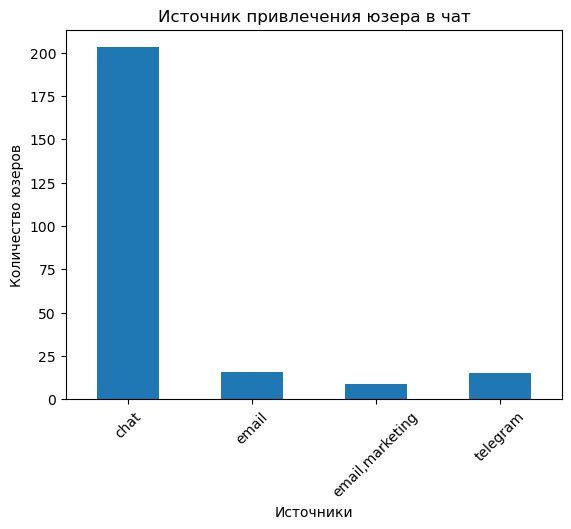

In [36]:
dialogs_df.drop_duplicates(subset='user_id').pivot_table(columns='segments',
                        aggfunc='nunique', values='user_id').T.plot(kind='bar', legend=False)

plt.xlabel('Источники')
plt.ylabel('Количество юзеров')
plt.title('Источник привлечения юзера в чат')
plt.xticks(rotation=45)  # Поворот подписей для читаемости

# Отображение графика
plt.show()

##### Был ли ответ саппорта перед закрытием диалога

In [73]:
dialogs_df['is_ftd'] = np.where(dialogs_df['sum ftd'] == 'without ftd', 0, 1)

In [532]:
print(f'Ответ оператора был в', round((dialogs_df[(dialogs_df['cnt_operator_messages'] != 0) &
                 (dialogs_df['status'] == 'resolved')]['id'].count() / 306) * 100, 2), '% случаев')
print('')
print(f'Ответа оператора не было в', 
      round((not_bot_dialogs[(not_bot_dialogs['cnt_operator_messages'] == 0) &
                 (not_bot_dialogs['status'] == 'resolved')]['id'].count() / 306) * 100, 2),
      '% случаев')

Ответ оператора был в 60.78 % случаев

Ответа оператора не было в 0.98 % случаев


In [510]:
unique_dialogs_list = messages_df[messages_df['author_type'] == 'bot']['conversation_id'].unique()

In [522]:
not_bot_dialogs = dialogs_df.query('id not in @unique_dialogs_list')

In [98]:
print(f'Ответ бота был', dialogs_df[(dialogs_df['cnt_bot_messages'] != 0) &
                 (dialogs_df['status'] == 'resolved')]['cnt_operator_messages'].count(), 'раз')
print('')
print(f'Ответа бота не было', 
      dialogs_df[(dialogs_df['cnt_bot_messages'] == 0) &
                 (dialogs_df['status'] == 'resolved')]['cnt_operator_messages'].count(), 'раз')

Ответ бота был 211 раз

Ответа бота не было 37 раз


In [100]:
print(f'Конверсия в FTD c ответом оператора (для закрытых диалогов)', 
      round(dialogs_df[(dialogs_df['cnt_operator_messages'] != 0) &
                 (dialogs_df['status'] == 'resolved')]['is_ftd'].mean()*100,2), '%')
print('')
print(f'Конверсия в FTD без ответа оператора (для закрытых диалогов)', 
      round(dialogs_df[(dialogs_df['cnt_operator_messages'] == 0) &
                 (dialogs_df['status'] == 'resolved')]['is_ftd'].mean()*100,2), '%')

Конверсия в FTD c ответом оператора (для закрытых диалогов) 27.42 %

Конверсия в FTD без ответа оператора (для закрытых диалогов) 4.84 %


In [534]:
print(f'Конверсия в FTD c ответом оператора', 
      round(dialogs_df[(dialogs_df['cnt_operator_messages'] != 0) &
                 (dialogs_df['status'] == 'resolved')]['is_ftd'].mean()*100,2), '%')
print('')
print(f'Конверсия в FTD без ответа оператора', 
      round(not_bot_dialogs[(not_bot_dialogs['cnt_operator_messages'] == 0) &
                 (not_bot_dialogs['status'] == 'resolved')]['is_ftd'].mean()*100,2), '%')

Конверсия в FTD c ответом оператора 27.42 %

Конверсия в FTD без ответа оператора 0.0 %


##### Если был ответ саппорта, был ли ответ клиента на ответ саппорта

In [120]:
print(f'Процент случаев, где был ответ клиента после ответа суппорта -', 
      (round(dialogs_df['operator_followed_by_user'].mean()*100, 2)), '%')

Процент случаев, где был ответ клиента после ответа суппорта - 37.91 %


##### Гео

In [128]:
def iso2_to_country(iso2):
    if not isinstance(iso2, str) or not iso2.strip():  # Проверяем на пустые и None
        return None  
    try:
        return pycountry.countries.get(alpha_2=iso2.upper()).name  # Приводим к верхнему регистру
    except AttributeError:
        return None

In [133]:
dialogs_df['geo_full'] = dialogs_df['geo'].apply(iso2_to_country)

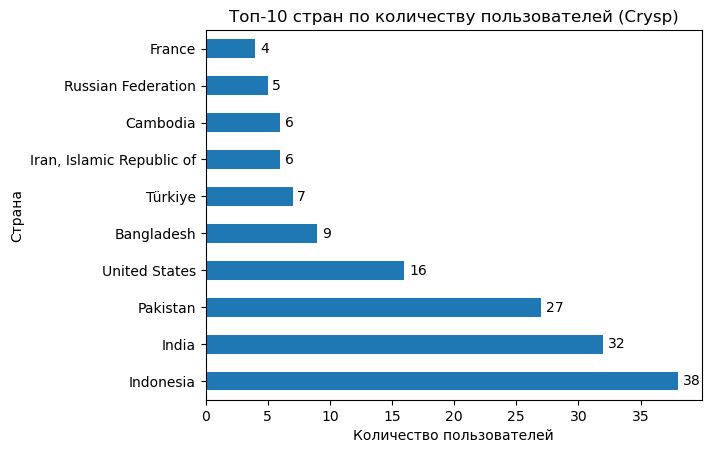

In [188]:
top_geos = (dialogs_df.drop_duplicates(subset='user_id')
                 .groupby('geo_full')['id']
                 .count()
                 .reset_index()
                 .sort_values(by='id', ascending=False)
                 [:10])
top_geos.plot(x='geo_full', y='id', kind='barh', legend=False)

# Настройка подписей
plt.ylabel('Страна')  # Подпись оси X
plt.xlabel('Количество пользователей')  # Подпись оси Y
plt.title('Топ-10 стран по количеству пользователей (Crysp)')
for index, value in enumerate(top_geos['id']):
    plt.text(value + max(top_geos['id']) * 0.01, index, str(value), va='center')

plt.show()

In [179]:
def iso3_to_country(iso3):
    if not isinstance(iso3, str) or not iso3.strip():  # Проверяем на пустые и None
        return None  
    try:
        return pycountry.countries.get(alpha_3=iso3.upper()).name  # Приводим к верхнему регистру
    except AttributeError:
        return None

In [182]:
dialogs_df['country_full'] = 
dialogs_df['country'].apply(iso3_to_country)

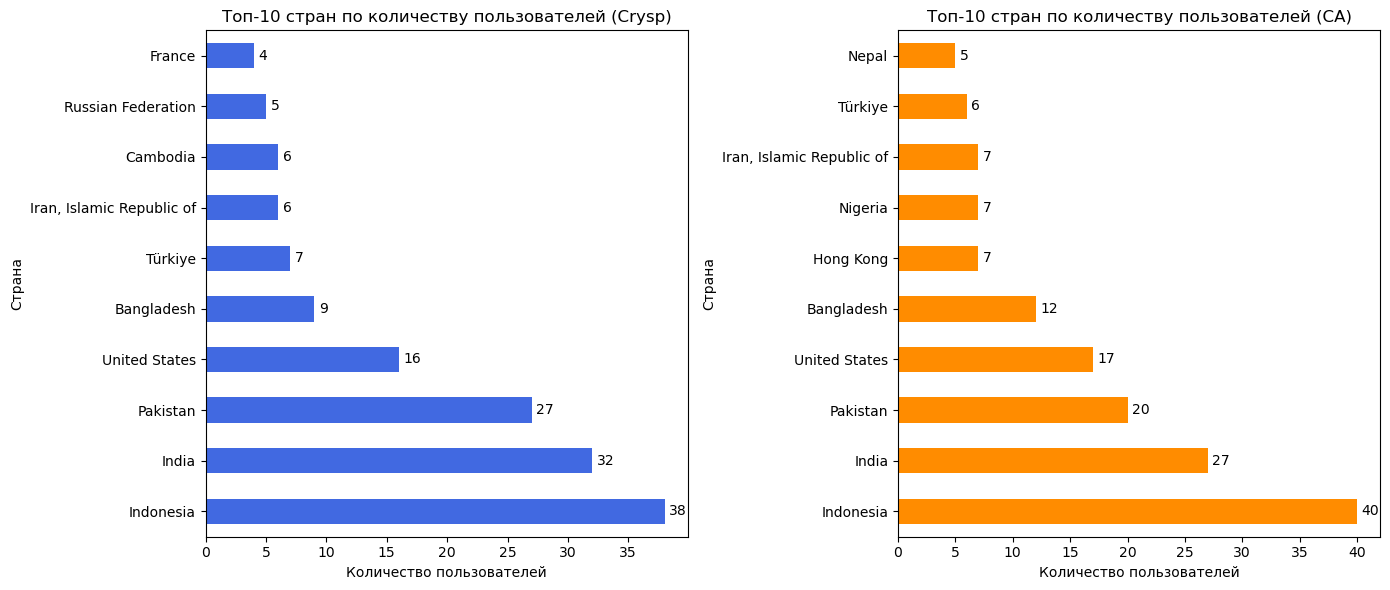

In [192]:
# Подготовка данных
top_geos = (dialogs_df.drop_duplicates(subset='user_id')
                 .groupby('geo_full')['id']
                 .count()
                 .reset_index()
                 .sort_values(by='id', ascending=False)
                 [:10])

top_countries = (dialogs_df.drop_duplicates(subset='user_id')
                 .groupby('country_full')['id']
                 .count()
                 .reset_index()
                 .sort_values(by='id', ascending=False)
                 [:10])

# Создаем фигуру с двумя графиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Один ряд, два столбца

# 🔹 График 1: Топ-10 стран (Crysp)
top_geos.plot(x='geo_full', y='id', kind='barh', legend=False, ax=ax1, color='royalblue')
ax1.set_ylabel('Страна')
ax1.set_xlabel('Количество пользователей')
ax1.set_title('Топ-10 стран по количеству пользователей (Crysp)')

# Добавляем подписи значений
for index, value in enumerate(top_geos['id']):
    ax1.text(value + max(top_geos['id']) * 0.01, index, str(value), va='center')

# 🔹 График 2: Топ-10 стран (CA)
top_countries.plot(x='country_full', y='id', kind='barh', legend=False, ax=ax2, color='darkorange')
ax2.set_ylabel('Страна')
ax2.set_xlabel('Количество пользователей')
ax2.set_title('Топ-10 стран по количеству пользователей (CA)')

# Добавляем подписи значений
for index, value in enumerate(top_countries['id']):
    ax2.text(value + max(top_countries['id']) * 0.01, index, str(value), va='center')

# Убираем наложения
plt.tight_layout()
plt.show()


##### Домен почты

In [197]:
dialogs_df['domain'] = dialogs_df['email'].str.split('@').str[1]

In [203]:
domains = dialogs_df['domain'].value_counts().reset_index()

In [207]:
domains_plot = domains[domains['count'] > 1]

In [218]:
print(f'Топ доменов (встречается чаще раза)\n', domains_plot)

Топ доменов (встречается чаще раза)
            domain  count
0       gmail.com    267
1     hotmail.com      6
2   peoplelabs.io      2
3  the-bithub.com      2
4      icloud.com      2
5       proton.me      2
6  sub4unlock.com      2
7  levelq.finance      2


##### Контакты

In [257]:
messengers = dialogs_df.merge(pd.read_csv('D:\\Users\\aleksandr.radionov\\Desktop\\users2.csv',
sep=';', on_bad_lines='skip')[['user_id', 'messenger']],
     on='user_id', how='left', suffixes=('x','_pivot'))['messenger_pivot'].value_counts(dropna=False).reset_index()

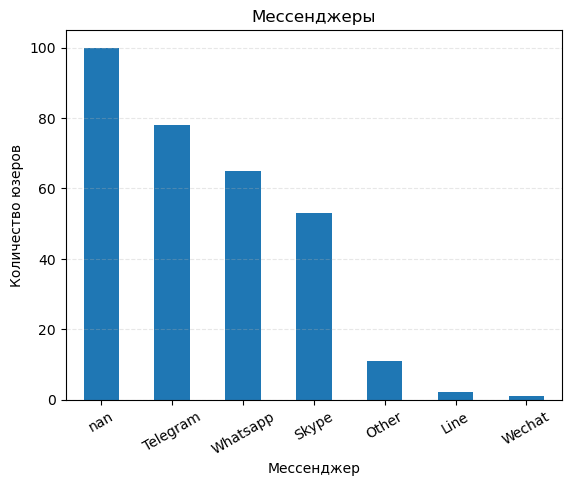

In [545]:
messengers.plot(kind='bar', x='messenger_pivot', y='count', legend=False)

plt.xlabel('Мессенджер')
plt.ylabel('Количество юзеров')
plt.title('Мессенджеры')
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=0.3, linestyle='--')
# Поворот подписей для читаемости

# Отображение графика
plt.show()

#### Исследование диалогов

##### Подключение к БД Крисп

In [11]:
import sqlalchemy as sql
from sqlalchemy import create_engine

In [12]:
db_config = {
'host': 'host',
'port' : 3306,
'db' : 'db',
'user' : 'user',
'pass' : 'pass',
}

In [13]:
connection_string = 'mysql+pymysql://{}:{}@{}/{}'.format(
    db_config['user'],
    db_config['pass'],
    db_config['host'],
    db_config['db'],
)

In [14]:
engine = create_engine(connection_string)

In [15]:
def select(sql):
  return pd.read_sql(sql, con=engine)

In [16]:
sql = '''
SELECT m.*,
o.username,
p.user_id
FROM messages m
LEFT JOIN operators o ON m.author_id = o.id AND m.author_type = 'operator'
LEFT JOIN people p ON m.author_id = p.id AND m.author_type = 'user'
WHERE conversation_id IN ('12', '18', '76', '77', '94', '110', '114', '134', '147', '167', '211', '212', '231', '232', '239', '273', '306', '333', '346', '347', '348', '349', '350', '351', '370', '389', '393', '404', '414', '428', '453', '479', '494', '501', '503', '504', '506', '507', '524', '533', '547', '577', '580', '594', '614', '623', '651', '660', '688', '696', '699', '712', '713', '735', '783', '794', '796', '797', '836', '860', '900', '917', '950', '953', '957', '977', '980', '1023', '1029', '1034', '1043', '1044', '1049', '1056', '1057', '1089', '1115', '1154', '1163', '1194', '1204', '1234', '1278', '1294', '1299', '1300', '1397', '1401', '1444', '1446', '1448', '1457', '1513', '1516', '1525', '1547', '1559', '1561', '1568', '1581', '1586', '1591', '1620', '1648', '1650', '1678', '1685', '1706', '1714', '1715', '1716', '1721', '1728', '1774', '1787', '1790', '1793', '1794', '1795', '1796', '1808', '1811', '1820', '1833', '1877', '1933', '1976', '1979', '1993', '2022', '2024', '2036', '2104', '2112', '2131', '2147', '2150', '2153', '2173', '2174', '2200', '2206', '2209', '2230', '2240', '2244', '2257', '2271', '2274', '2283', '2299', '2326', '2328', '2344', '2367', '2370', '2379', '2387', '2411', '2429', '2442', '2446', '2510', '2567', '2568', '2581', '2601', '2611', '2649', '2659', '2660', '2661', '2662', '2663', '2664', '2665', '2682', '2683', '2684', '2702', '2704', '2710', '2716', '2717', '2723', '2748', '2752', '2796', '2815', '2847', '2874', '2887', '2903', '3000', '3025', '3026', '3033', '3040', '3059', '3063', '3070', '3083', '3114', '3117', '3118', '3138', '3156', '3158', '3163', '3176', '3177', '3182', '3188', '3263', '3266', '3276', '3279', '3289', '3290', '3292', '3317', '3336', '3349', '3351', '3356', '3357', '3361', '3376', '3385', '3390', '3391', '3424', '3429', '3431', '3446', '3466', '3474', '3481', '3482', '3483', '3493', '3506', '3507', '3508', '3513', '3515', '3521', '3522', '3536', '3540', '3546', '3547', '3550', '3551', '3555', '3556', '3558', '3580', '3581', '3582', '3583', '3589', '3596', '3598', '3599', '3617', '3618', '3620', '3622', '3623', '3625', '3629', '3637', '3639', '3640', '3646', '3685', '3686', '3759', '3780', '3792', '3806', '3825', '3873', '3874', '3911', '3922', '4036', '4043', '4049', '4063', '4077', '4092', '4191', '4221', '4227', '4302', '4311', '4345', '4355', '4386', '4419', '4461', '4466')
'''

In [19]:
messages_df = select(sql)

In [20]:
messages_df_copy = messages_df.copy()

In [21]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4594 entries, 0 to 4593
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4594 non-null   int64         
 1   author_type       4594 non-null   object        
 2   author_id         2709 non-null   object        
 3   conversation_id   4594 non-null   int64         
 4   text              4594 non-null   object        
 5   read              4594 non-null   object        
 6   delivered         4594 non-null   object        
 7   internal_message  4594 non-null   int64         
 8   created_at        4594 non-null   datetime64[ns]
 9   username          841 non-null    object        
 10  user_id           1606 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 394.9+ KB


##### Обработка данных

In [22]:
users_messages = messages_df[messages_df['author_type'] == 'user']

In [23]:
users_messages['user_id'] = users_messages['user_id'].astype(int)

D:\Users\aleksandr.radionov\AppData\Local\Temp\1\ipykernel_9128\4074746986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_messages['user_id'] = users_messages['user_id'].astype(int)


In [24]:
users_messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, 0 to 4590
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                1606 non-null   int64         
 1   author_type       1606 non-null   object        
 2   author_id         1606 non-null   object        
 3   conversation_id   1606 non-null   int64         
 4   text              1606 non-null   object        
 5   read              1606 non-null   object        
 6   delivered         1606 non-null   object        
 7   internal_message  1606 non-null   int64         
 8   created_at        1606 non-null   datetime64[ns]
 9   username          0 non-null      object        
 10  user_id           1606 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(3), object(6)
memory usage: 144.3+ KB


In [25]:
first_3 = users_messages.sort_values(by=['conversation_id',
                               'created_at']).groupby('conversation_id').head(3).reset_index(drop=True)

In [26]:
first_3.head(9)

,id,author_type,author_id,conversation_id,text,read,delivered,internal_message,created_at,username,user_id
0,156,user,03dad69f-b1e4-4e5a-8d02-cee14afac5a5,12,"Hi,",chat,,0,2025-03-07 11:26:51,None,176221
1,165,user,03dad69f-b1e4-4e5a-8d02-cee14afac5a5,12,customer,chat,,0,2025-03-07 11:27:46,None,176221
2,169,user,03dad69f-b1e4-4e5a-8d02-cee14afac5a5,12,customer representative,chat,,0,2025-03-07 11:28:07,None,176221
3,255,user,0c26f985-40dd-4b00-8bae-ad0e0373537c,18,Почему у меня на компании # 376801 написано чт...,chat,,0,2025-03-06 15:03:23,None,173996
4,261,user,0c26f985-40dd-4b00-8bae-ad0e0373537c,18,?,chat,,0,2025-03-06 15:18:44,None,173996
5,262,user,0c26f985-40dd-4b00-8bae-ad0e0373537c,18,"вопрос снят, спасибо",chat,,0,2025-03-06 15:21:52,None,173996
6,1270,user,3f3cd1c8-2a37-4cc9-947b-03f5d4fa82b2,76,hello,chat,,0,2025-03-04 11:51:12,None,175504
7,1277,user,3f3cd1c8-2a37-4cc9-947b-03f5d4fa82b2,76,"{""name"":""Screen Shot 2025-03-04 at 11.51.27.pn...",email,email,0,2025-03-04 11:52:08,None,175504
8,1283,user,3f3cd1c8-2a37-4cc9-947b-03f5d4fa82b2,76,hello,chat,,0,2025-03-07 14:16:05,None,175504


Данные корректны для анализа

##### Посмотрим на язык сообщений

In [6]:
model = fasttext.load_model("lid.176.bin")

In [30]:
# Функция для определения языка
def detect_language_fasttext(text):
    text = str(text).replace("\n", " ").strip()  # Убираем переносы строк
    lang, confidence = model.predict(text, k=1)
    return lang[0].replace("__label__", ""), confidence[0]

In [29]:
first_3[['fasttext_lang', 'fasttext_confidence']] = first_3['text'].apply(lambda x:
                                                                    pd.Series(detect_language_fasttext(str(x))))

In [34]:
# Функция для преобразования кода языка в прилагательное (английский формат)
def get_language_adjective(lang_code):
    try:
        lang_name = pycountry.languages.get(alpha_2=lang_code).name  # Полное название языка
        return lang_name.lower()  # Например, "russian", "english"
    except AttributeError:
        return 'other'

In [35]:
first_3['language'] = first_3['fasttext_lang'].apply(get_language_adjective)

In [39]:
print(f'Топ 10 языков сообщений:\n', first_3['language'].value_counts()[:10].reset_index())

Топ 10 языков сообщений:
      language  count
0     english    459
1     russian     30
2     catalan     20
3  indonesian     17
4     spanish     16
5     persian     14
6      french     13
7      german      8
8      arabic      8
9     italian      4


##### Изучим самые повторяющиеся слова

###### nltk

In [352]:
nltk.download('stopwords')
all_stopwords = set(stopwords.words('russian') + stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\aleksandr.radionov\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Unzipping corpora\stopwords.zip.


In [353]:
# Функция для предобработки текста
def preprocess_text(text):
    text = text.lower()  # Нижний регистр
    text = re.sub(r'[^\w\s]', '', text)  # Убираем знаки препинания
    text = re.sub(r'\d+', '', text)  # Убираем цифры
    return text

In [438]:
# Функция для подсчёта частотности слов
def get_most_common_words(texts, n=30):
    words = []
    
    for text in texts:
        processed_text = preprocess_text(text)
        words.extend(word for word in processed_text.split() if word not in all_stopwords)
    
    return Counter(words).most_common(n)

In [442]:
print(f'Топ 30 наиболее встречаемых слов в диалогах') 
get_most_common_words(first_3['text'])

Топ 30 наиболее встречаемых слов в диалогах


[('hello', 80),
 ('onclicka', 64),
 ('hi', 57),
 ('ads', 54),
 ('want', 49),
 ('ad', 43),
 ('campaign', 40),
 ('account', 39),
 ('campaigns', 39),
 ('start', 34),
 ('wrote', 31),
 ('help', 31),
 ('im', 31),
 ('manager', 28),
 ('get', 28),
 ('clickadilla', 27),
 ('please', 27),
 ('telegram', 27),
 ('balance', 27),
 ('email', 26),
 ('code', 25),
 ('traffic', 24),
 ('dont', 24),
 ('image', 21),
 ('bonus', 20),
 ('money', 19),
 ('personal', 19),
 ('rachael', 19),
 ('welcome', 19),
 ('know', 18)]

Аномалий в списке не видно, слово money встречается 19 раз.
<p>Можем зафиксировать самый частый запрос/проблему : <b>ads/ad, campaign, manager, telegram, balance, email, code, traffic, image, bonus, money

In [481]:
first_3[first_3['text'].str.contains(r'\bmoney\b', case=False, na=False, regex=True)]['text']

19                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 I deposited money but it did not arrive
20                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 I deposited money but it d

Видим слово money встречается только в контексте пополнений, так же нашли один refund

###### Sklearn

In [43]:
custom_stop_words = [
    'the', 'and', 'you',
    'but', 'or', 'for', 'your', 'it', 'or', 'not', 'am', 'this', 'are', 'no', 'that', 'what', 'we',
    'on', 'at', 'by', 'in', 'to', 'of', 'a', 'an', 'my', 'me', 'is', 'with', 'how', 'can', 'our',  # Английские предлоги
    'в', 'на', 'с', 'по', 'к', 'из', 'для', 'от', 'и', 'но', 'или', 'для', 'за', 'о'  # Русские предлоги
]

In [44]:
vectorizer = TfidfVectorizer(
    stop_words=custom_stop_words,  # Убираем стоп-слова
    ngram_range=(1, 2),  # Учитываем и слова, и биграммы (двухсловные сочетания)
    max_features=30  # Оставляем топ-30 самых значимых
)

In [45]:
X = vectorizer.fit_transform(first_3['text'])

In [46]:
words = vectorizer.get_feature_names_out()
importance = X.toarray().sum(axis=0)

In [49]:
print(f'Слова расставленые в порядке важности \n', 
pd.DataFrame({'word': words,
'importance': importance}).sort_values(by='importance', ascending=False).reset_index(drop=True).head(22))

Слова расставленые в порядке важности 
             word  importance
0          hello   53.576330
1             hi   42.017448
2           want   36.254761
3            ads   34.763834
4       onclicka   23.549535
5          https   22.045275
6           have   21.423623
7          start   21.330950
8            com   19.840823
9             ad   18.506372
10       account   18.401265
11      campaign   17.591891
12      telegram   16.462307
13         image   11.445103
14          help   10.905364
15  onclicka com    9.901251
16          here    9.738577
17           png    9.523890
18       support    7.934068
19   clickadilla    7.689623
20     campaigns    7.559644
21          2025    6.086717


Как интерпретировать диапазон 5–50 (важность)?
Значение TF-IDF	Интерпретация
40–50	Суперважные слова – определяют главные темы
20–39	Значимые фразы – часто встречаются, но не во всех текстах
5–19	Менее важные, но полезные слова – встречаются в нескольких текстах

Среди важных слов нет слова money. <p> Какие слова можем выделить как важные : <b>ads/ad, start, campaign, account, telegram, image, png, support

##### Изучим тональность сообщений

In [52]:
# Загружаем модель для анализа тональности
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment")

Device set to use cpu


In [50]:
# Функция анализа тональности с BERT
def analyze_sentiment_bert(text):
    truncated_text = text[:512]  # Обрезаем текст до 512 символов
    result = sentiment_pipeline(truncated_text)[0]  # Берём первый результат
    label = result['label']  # 'positive', 'neutral' или 'negative'
    score = result['score']  # Уверенность модели (0.5 - 1.0)
    
    # Преобразуем в числовые значения
    sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
    return sentiment_map[label], round(score, 2)

In [53]:
# Анализируем тональность
first_3[['sentiment_score', 
         'confidence']] = first_3['text'].apply(lambda x: pd.Series(analyze_sentiment_bert(x)))

In [60]:
print(f'Средняя тональность сообщений', round(first_3['sentiment_score'].mean(), 3))

Средняя тональность сообщений -0.07


In [59]:
print(f'Уверенность модели в результате', round(first_3['confidence'].mean(), 2))

Уверенность модели в результате 0.62


Мы поделили с помощью модели машинного обучения каждое сообщение на три группы по тональности : позитивное, нейтральное, негативное.<p> В итоге мы получили среднюю тональность -0.069, что говорит о том, что в общем сообщения близки к нейтральным, со склонностью к негативу. <p> Здесь стоит добавить, что уверенность модели в своей оценке в среднем составляет 62.3%, что говорит о том, что модель зачастую сомневается в оценке

##### Анализ вопросов

In [428]:
question_words = {
    'who', 'what', 'where', 'when', 'why', 'how', 'which', 'whose', 'whom',  # Классические вопросительные слова
    'do', 'does', 'did', 'can', 'could', 'should', 'would', 'will', 'is', 'are', 'was', 'were', 'may', 'might',  # Вопросительные глаголы
    'am', 'have', 'has', 'had', 'shall', 'must', 'ought', 'need', 'dare',  # Дополнительные модальные глаголы
    'what kind', 'how much', 'how many', 'how long', 'how far', 'how old', 'how come',  # Вопросительные фразы
}

In [464]:
# Функция для определения вопросов
def is_question(text):
    text = text.lower()
    return any(word in text.split() for word in question_words) or '?' in text

In [465]:
# Фильтруем вопросы
df_questions = first_3[first_3['text'].apply(is_question)]

# Очистка текста
def clean_text(text):
    text = text.lower()  # Приводим к нижнему регистру
    text = re.sub(r'[^\w\s?]', '', text)  # Убираем всё, кроме `?`
    return text

In [432]:
df_questions['clean_text'] = df_questions['text'].apply(clean_text)

D:\Users\aleksandr.radionov\AppData\Local\Temp\1\ipykernel_6740\1305742692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_questions['clean_text'] = df_questions['text'].apply(clean_text)


In [437]:
# Загружаем стандартные стоп-слова
stop_words = set(stopwords.words('english'))

# Добавляем кастомные слова, которые мешают анализу
custom_stopwords = {'your', 'you', 'i', 'my', 'is', 'are', 'can', 'on', 'in', 'the', 'to', 'a', 'and', 'hi', 
                    'hello', 'im'}
stop_words.update(custom_stopwords)

# Векторизация вопросов с учетом TF-IDF
vectorizer = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))
X = vectorizer.fit_transform(df_questions['clean_text'])

# Получаем слова и их значения TF-IDF
tfidf_scores = np.asarray(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

# Создаём DataFrame с результатами
word_tfidf = pd.DataFrame({'word': words, 'tfidf': tfidf_scores})
word_tfidf = word_tfidf.sort_values(by="tfidf", ascending=False)

# Выводим топ-30 значимых слов и фраз
print("\n🔹 Топ-30 самых значимых слов/фраз в вопросительных предложениях:")
print(word_tfidf.head(30).reset_index(drop=True))



🔹 Топ-15 самых значимых слов/фраз в вопросительных предложениях:
           word     tfidf
0           ads  6.076593
1          work  4.895910
2      onclicka  4.442881
3       traffic  4.263395
4          help  4.220852
5            ad  4.096310
6          want  3.973196
7     publisher  3.963516
8      telegram  3.887918
9       account  3.778207
10         need  3.504785
11     campaign  3.128056
12      website  2.938904
13          add  2.867812
14          get  2.802060
15      balance  2.704236
16         know  2.627872
17       refund  2.482284
18         code  2.482250
19    campaigns  2.411856
20         link  2.404689
21        adult  2.243548
22      manager  2.212031
23  clickadilla  2.160123
24      support  2.159250
25        bonus  2.130573
26         2025  2.128899
27        email  2.127662
28          use  2.125638
29          pay  2.119797


Если говорить о самых важных словах в вопросах, то это : <b>ads/ad, work, traffic, help

In [480]:
first_3[first_3['text'].str.contains(r'\bwork\b', case=False, na=False, regex=True)]['text']

16                                                                                                                                                                                                                                                                                                                                                                                                                   My tracker is Binom and I set up postback but it doesn't work and I don't see installs in my dashbord
71                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             how does this 

Видим что слово work используется только в контексте вопросов касающихся платформы

##### Анализ капслока

In [458]:
# Функция для детекции капслока
def detect_capslock(text):
    words = text.split()
    total_words = len(words)
    
    if total_words == 0:
        return "No Text"
    
    caps_words = sum(1 for word in words if word.isupper())  # Считаем капслочные слова
    caps_ratio = caps_words / total_words  # Доля капслочных слов в тексте

    if text.isupper():  # Если весь текст в капсе
        return "1"
    elif caps_ratio > 0.5:  # Если больше половины слов в капсе
        return ">0.5"
    elif caps_ratio > 0:  # Если есть отдельные слова в капсе
        return ">0"
    else:
        return "No Caps"


In [460]:
first_3['capslock_status'] = first_3['text'].apply(detect_capslock)

In [463]:
print(f'Количество закапслоченных сообщений\n', first_3['capslock_status'].value_counts())

Количество закапслоченных сообщений
 capslock_status
No Caps    469
>0         142
1            6
>0.5         1
Name: count, dtype: int64


Три четверти сообщений написана без капслока, четверть с ним. Так же встречаются сообщения, полностью написанные капслоком

In [483]:
first_3[first_3['text'].str.isupper()]['text']

171                               JUJU JIJI
185    CAN YOU IGVE ME YOUR TRAFFIC QUALITY
186                                DETAISLS
278                                    BRUH
323                                  TLG500
415                                      HI
Name: text, dtype: object

#### Выводы

Новореги поступают с логичными запросами к платформе, аномальных запросов не выявлено.